In [ ]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

In [39]:
# ---- STEP 1: Prepare data ----
match_points = [0, 0, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 0, 3, 1, 3]
n = len(match_points)

# Map match outcomes to class indices (needed for Categorical)
points_map = {0: 0, 1: 1, 3: 2}
match_classes = np.array([points_map[pt] for pt in match_points])
n_categories = 3

In [40]:
# ---- STEP 2: Define Bayesian model ----
with pm.Model() as model:
    tau = pm.DiscreteUniform("tau", lower=0, upper=n)
    p1 = pm.Dirichlet("p1", a=np.ones(n_categories))
    p2 = pm.Dirichlet("p2", a=np.ones(n_categories))

    p_all = pm.math.stack([p1, p2])
    selector = (np.arange(n) >= tau).astype("int32")
    p = p_all[selector]

    obs = pm.Categorical("obs", p=p, observed=match_classes)
    trace = pm.sample(3000, tune=1000, target_accept=0.95, random_seed=42)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [p1, p2]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 37 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [42]:
# ---- STEP 3: Extract and reshape samples ----
p1_samples = trace.posterior["p1"].values.reshape(-1, 3)  # (n_samples, 3)
p2_samples = trace.posterior["p2"].values.reshape(-1, 3)
tau_samples = trace.posterior["tau"].values.flatten()   

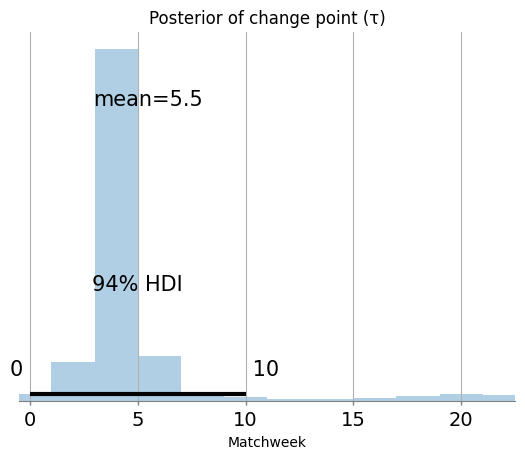

In [43]:
# ---- STEP 6: Visualize the change point ----
az.plot_posterior(trace, var_names=["tau"])
plt.title("Posterior of change point (τ)")
plt.xlabel("Matchweek")
plt.grid(True)
plt.show()

In [48]:
# ---- STEP 4: Compute mean outcome probabilities ----
# Get the samples where tau is before/after the halfway point
cut_point = 6
before_mask = tau_samples <= cut_point
after_mask = tau_samples > cut_point

# Mean outcome probabilities
p1_mean = p1_samples[before_mask].mean(axis=0)
p2_mean = p2_samples[after_mask].mean(axis=0)


In [49]:
# ---- STEP 5: Print results ----
index_to_points = {0: "0 points", 1: "1 point", 2: "3 points"}

print("📊 Estimated outcome probabilities BEFORE the change point:")
for i, p in enumerate(p1_mean):
    print(f"  {index_to_points[i]}: {p:.3f}")

print("\n📊 Estimated outcome probabilities AFTER the change point:")
for i, p in enumerate(p2_mean):
    print(f"  {index_to_points[i]}: {p:.3f}")



📊 Estimated outcome probabilities BEFORE the change point:
  0 points: 0.519
  1 point: 0.335
  3 points: 0.146

📊 Estimated outcome probabilities AFTER the change point:
  0 points: 0.187
  1 point: 0.258
  3 points: 0.554


In [11]:
print("p1_samples shape:", p1_samples.shape)


p1_samples shape: (3, 12000)
